# This is a script to run automated crawling

### Import necessary libaries

In [37]:
import json
import subprocess
import matplotlib.pyplot as plt
import pandas as pd

### Set plotting params

In [38]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### Define needed constants

In [39]:
JAR_FILE_PATH = '/home/gorq/Desktop/VWM/walker_2.0/out/artifacts/walker_2_0_jar/walker_2.0.jar'
DB_URL = 'localhost:3306'
DB_NAME = 'market'
USERNAME = 'gorq'
PASSWORD = 'hesloheslo'

### Define an experiment class

In [40]:
class Experiment:
    def __init__(self, dct: dict) -> None:
        self._dct = dct
    
    @property
    def timeout(self) -> int:
        return self._dct['timeout']
    
    @property
    def request_limit(self) -> int:
        return self._dct['request limit']
    
    @property
    def ordering(self) -> str:
        return self._dct['ordering']
    
    @property
    def average_depth(self) -> float:
        return self._dct['average depth']
    
    @property
    def average_branching(self) -> float:
        return self._dct['average branching']
    
    @property
    def C(self) -> float:
        return self._dct['walker']['C']
    
    @property
    def acquired_amount(self) -> int:
        return self._dct['walker']['acquired amount']
    
    @property
    def unaccepted_amount(self) -> int:
        return self._dct['not accepted']
    
    @property
    def report_frequency(self) -> float:
        return self._dct['reporter']['frequency']
    
    @property
    def progress_list(self) -> list:
        return self._dct['reporter']['acquired times']
    
    def toPSV(self) -> str:
        return f'\
{self.timeout}|\
{self.request_limit}|\
{self.ordering}|\
{self.C}|\
{self.average_depth}|\
{self.average_branching}|\
{self.report_frequency}|\
{self.progress_list}|\
{self.acquired_amount}|\
{self.unaccepted_amount}\
'
    
    def graph(self) -> None:
        plt.rcParams['figure.figsize'] = (12, 7)
        plt.rcParams['font.size'] = 13
        plt.ylabel('Acquired amount')
        plt.xlabel('Time passed (seconds)')
        
        plt.grid(True)
        
        plt.plot(
            [0]+[ self.report_frequency*x for x in range(1, len(self.frequency_list)+1)],
            [0]+self.frequency_list,
            label='Progress'
        )
        
        
        plt.legend()
        plt.show()
        
        
    def outputInfo(self) -> None:
        print(self)
        self.graph()
    
    def __str__(self) -> str:
        return f'''
--------------------------------------------------------
| Timeout: {self.timeout} seconds
| Request limit: {self.request_limit}
| Ordering: {self.ordering}
| C: {self.C}
| Average depth: {self.average_depth}
| Average branching: {self.average_branching}
| Report frequency: {round(1/self.report_frequency, 3)} updates per second
| Progress list sample: {self.progress_list[:5]}...
| Acquired amount: {self.acquired_amount}
| Not accepted amount: {self.unaccepted_amount}
--------------------------------------------------------
'''

### Create a function to run an experiment

In [41]:
def run_experiment(
        db_url: str,
        db_name: str,
        username: str,
        password: str,
        *_,
        timeout: int = 10,
        request_limit: int = 1,
        C: int = 3,
        frequency: float = 1,
        file_out: str,
        ordering: str = 'fixed',
        wanted: int
    ) -> Experiment:
    to_run = f'''
        java -jar {JAR_FILE_PATH}
        --db-url {db_url}
        --db-name {db_name}
        --username {username}
        --password {password}
        --timeout {timeout}
        --request-limit {request_limit}
        --wanted-sample {wanted}
        --set-c {C}
        --report-frequency {frequency}
        --output {file_out}
        --ordering {ordering}
    '''
    
    process = subprocess.Popen(to_run.split(), stdout=subprocess.PIPE)
    o, e = process.communicate()
    
    with open(file_out, 'r') as f:
        return Experiment(json.load(f))

### Create a function to save an experiment into csv

In [42]:
def save_experiment(exper: Experiment, file_name: str) -> None:
    with open(file_name, 'a') as f:
        f.write(exper.toPSV() + '\n')

### Define a function to determine how the experiments are to run

In [43]:
def run_experiments(
        *_,
        timeouts: list,
        C_s: list,
        limits: list,
        orderings: list,
        output_csv: str,
        num_of_reports: int,
        wanted_sample: int,
        run_times: int
    ) -> None:
    
    
    for _ in range(run_times):
        for _timeout in timeouts:
            for _C in C_s:
                for _limit in limits:
                    for _ordering in orderings:
                        print(f'{_timeout}:{_C}:{_limit}:{_ordering}')
                        frequency = _timeout/num_of_reports
                        my_exp = run_experiment(
                            DB_URL,
                            DB_NAME,
                            USERNAME,
                            PASSWORD,
                            file_out = 'dummy.json',
                            timeout = _timeout,
                            C = _C,
                            frequency = frequency,
                            request_limit = _limit,
                            ordering = _ordering,
                            wanted = wanted_sample,
                        )
                        save_experiment(my_exp, output_csv)
                
    print('Finished!!!')

### Create csv file

In [44]:
csv_out = 'experiment_out.csv'

'''
with open(csv_out, 'w') as f:
    f.write('\
Timeout|\
Limit|\
Ordering|\
C|\
Average depth|\
Average branching|\
Report frequency|\
Progress list|\
Acquired amount|\
Unaccepted amount' + '\n')
'''

"\nwith open(csv_out, 'w') as f:\n    f.write('Timeout|Limit|Ordering|C|Average depth|Average branching|Report frequency|Progress list|Acquired amount|Unaccepted amount' + '\n')\n"

## Now run the experiments

### These are the tests that have been run:
#### 1 minute for each top-k [1, 2, 3, 5, 10, 20, 50]
#### fixed and random attribute traversal ordering
#### 2 reports per second
#### Experimenting with C-parameter [-20 to 20], step = 0.5

In [45]:
run_times = 1
# Define max records to stop computations early
# (this is just convenience so that the runs can stop early and we can do more simulations)
DB_RECORDS = 1000
timeouts = [60]
C_s = [-10 + (.5*x) for x in range(0, 41)]
limits = [1, 2, 3, 5, 10, 50]
orderings = ['random', 'fixed']
num_of_reports = 120


'''
run_experiments(
    timeouts = timeouts,
    C_s = C_s,
    limits = limits,
    orderings= orderings,
    output_csv = csv_out,
    num_of_reports = num_of_reports,
    wanted_sample = DB_RECORDS,
    run_times = run_times
)
'''

'\nrun_experiments(\n    timeouts = timeouts,\n    C_s = C_s,\n    limits = limits,\n    orderings= orderings,\n    output_csv = csv_out,\n    num_of_reports = num_of_reports,\n    wanted_sample = DB_RECORDS,\n    run_times = run_times\n)\n'

## Read the dataframe produced

In [46]:
df = pd.read_csv(csv_out, sep='|', header=0, index_col=False)
df.head()

,Timeout,Limit,Ordering,C,Average depth,Average branching,Report frequency,Progress list,Acquired amount,Unaccepted amount
0,60,1,random,-10.0,19.175361,3.190446,0.5,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",4,3178
1,60,1,fixed,-10.0,15.355239,3.703814,0.5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,4351
2,60,2,random,-10.0,18.095465,3.379714,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4190
3,60,2,fixed,-10.0,14.566847,4.216914,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,5924
4,60,3,random,-10.0,17.302079,3.433390,0.5,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",3,4713


## Now let's try to get some intel from the runs we have ran

## Let's try to find what was the optimal value of C for different parameters

### Let's plot it for better understanding

In [47]:
def plot_exp(*_, k: int) -> None:
    plt.title(f'Effect of C for k in top-k {k} in 1 minute')
    plt.xlabel('C value')
    plt.ylabel('Amount')
    plt.grid(True)
    #plt.ylim(0, 1200)
    
    top_k_df = df.loc[df['Limit'] == k]
    
    # Plot when random ordering
    random_ordered = list(top_k_df.merge(df.loc[df['Ordering'] == 'random'])['Acquired amount'])
    plt.plot(C_s[15:40], random_ordered[15:40], label='Random ordering (acquired)', color='blue')
    # Plot unnaccepted amount
    random_ordered_ua = list(top_k_df.merge(df.loc[df['Ordering'] == 'random'])['Unaccepted amount'])
    plt.plot(C_s[15:40], random_ordered_ua[15:40], label='Random ordering (unaccepted)', color='aqua')
    
    # Plot when fixed ordering
    fix_ordered = list(top_k_df.merge(df.loc[df['Ordering'] == 'fixed'])['Acquired amount'])
    plt.plot(C_s[15:40], fix_ordered[15:40], label='Fixed ordering (acquired)', color='red')
    # Plot unnaccepted amount
    fix_ordered_ua = list(top_k_df.merge(df.loc[df['Ordering'] == 'fixed'])['Unaccepted amount'])
    plt.plot(C_s[15:40], fix_ordered_ua[15:40], label='Fixed ordering (unaccepted)', color='orange')
    
    plt.legend();

## For k == 1

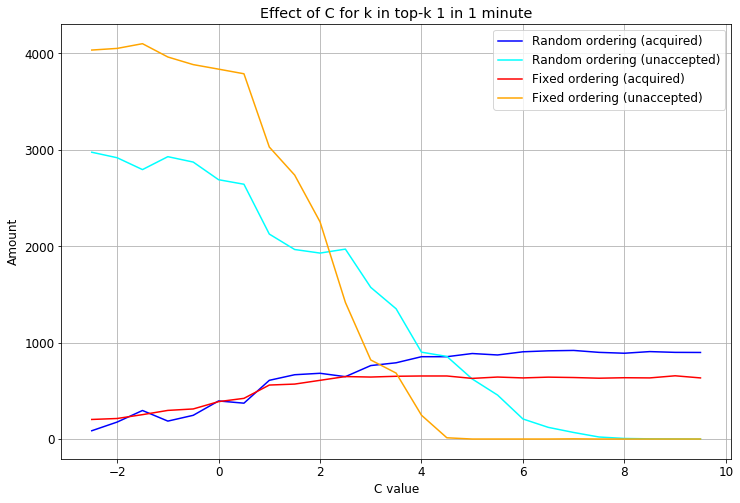

In [48]:
plot_exp(k=1)

## For k == 2

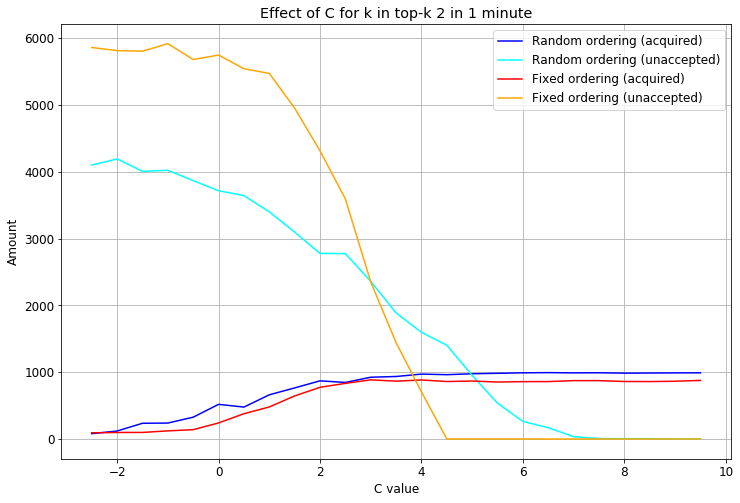

In [49]:
plot_exp(k=2)

## For k == 3

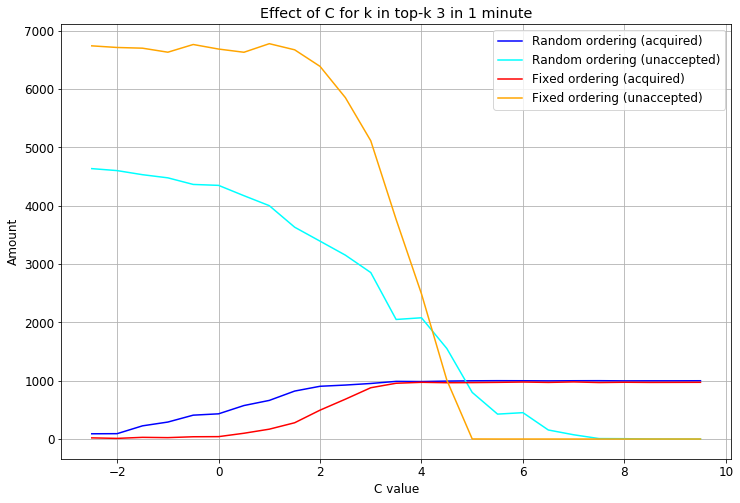

In [50]:
plot_exp(k=3)

## For k == 5

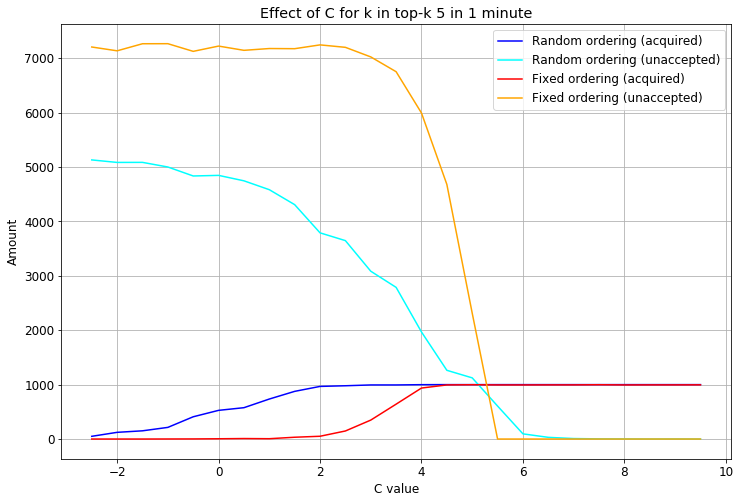

In [51]:
plot_exp(k=5)

## For k == 10

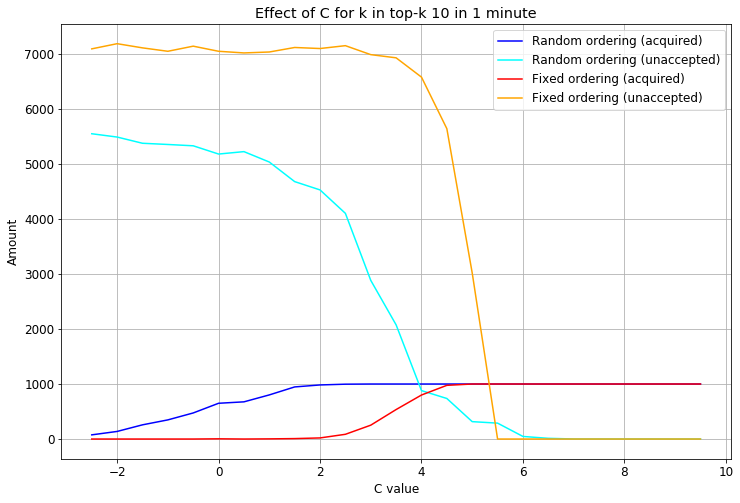

In [52]:
plot_exp(k=10)

## And for k == 20

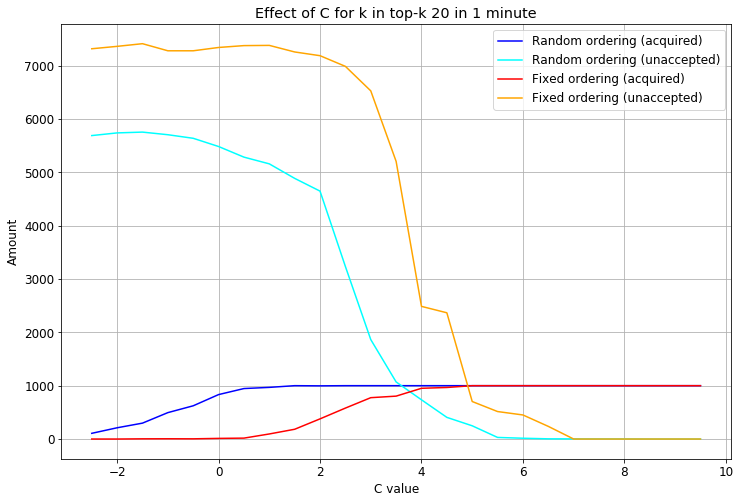

In [53]:
plot_exp(k=20)